# 0.0 IMPORTS

In [5]:
import re
import inflection

import numpy   as np
import pandas  as pd
import seaborn as sns

# import umap.umap_ as umap


from sklearn import cluster       as c
from sklearn import metrics       as m
from sklearn import preprocessing as pp

import matplotlib.pyplot as plt

from IPython.display import HTML


## 0.2 Helper Functions

In [6]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.3 Load Data

In [7]:
# df_raw = pd.read_csv( 'Ecommerce.csv', encoding='cp1252' )
# load data
df_raw = pd.read_csv( '../data/raw/Ecommerce.csv' )

# drop extra column
df_raw = df_raw.drop( columns=['Unnamed: 8'], axis=1 )

In [8]:
df_raw.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
214350,555572,22382,LUNCH BAG SPACEBOY DESIGN,10,3-Jun-17,1.65,12449.0,Belgium
171279,551400,84970S,HANGING HEART ZINC T-LIGHT HOLDER,12,26-Apr-17,0.85,17160.0,United Kingdom
448005,575003,22840,ROUND CAKE TIN VINTAGE RED,2,6-Nov-17,7.95,15950.0,United Kingdom
167773,551004,22197,SMALL POPCORN HOLDER,2,24-Apr-17,1.63,NaN,United Kingdom
440553,574536,22977,DOLLY GIRL CHILDRENS EGG CUP,4,2-Nov-17,1.25,15707.0,United Kingdom
115277,546115,22418,10 COLOUR SPACEBOY PEN,24,7-Mar-17,0.85,15379.0,United Kingdom
497699,578463,23240,SET OF 4 KNICK KNACK TINS DOILY,6,22-Nov-17,4.15,12757.0,Portugal
143240,548670,22998,TRAVEL CARD WALLET KEEP CALM,3,30-Mar-17,0.42,15356.0,United Kingdom
20020,538003,22365,DOORMAT RESPECTABLE HOUSE,2,7-Dec-16,7.95,12429.0,Denmark
300916,563216,17129F,BLUE GLASS GEMS IN BAG,7,12-Aug-17,0.85,17841.0,United Kingdom


# 1.0 DATA DESCRIPTION

## Attribute Description
**InvoiceNo** - Invoice number (A 6-digit integral number uniquely assigned to each transaction)

**StockCode** - Product (item) code

**Description** - Product (item) name

**Quantity** - The quantities of each product (item) per transaction

**InvoiceDate** - The day when each transaction was generated

**UnitPrice** - Unit price (Product price per unit)

**CustomerID** - Customer number (Unique ID assigned to each customer)

**Country** Country name (The name of the country where each customer resides)

Analysis tasks to be performed:

Use the clustering methodology to segment customers into groups:

Use the following clustering algorithms:

In [9]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [10]:
# List of columns name
old_columns = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

# Change to snakecase
snakecase = lambda x: inflection.underscore( x )

new_columns = list( map( snakecase, old_columns ) )

df1.columns = new_columns

In [11]:
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

## 1.2 Data Dimension

In [12]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Columns: {}'.format( df1.shape[1] ) )

Number of Rows: 541909
Number of Columns: 8


## 1.3 Data Types

In [13]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [14]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [15]:
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

In [16]:
# create reference
df_backup = pd.DataFrame( df_missing['invoice_no'].drop_duplicates() )
df_backup['customer_id'] = np.arange( 19000, 19000+len( df_backup ), 1)

# merge original with reference dataframe
df1 = pd.merge( df1, df_backup, on='invoice_no', how='left' )

# coalesce 
df1['customer_id'] = df1['customer_id_x'].combine_first( df1['customer_id_y'] )

# drop extra columns
df1 = df1.drop( columns=['customer_id_x', 'customer_id_y'], axis=1 )

In [17]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Change Dtypes

In [18]:
# invoice_date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer_id
df1['customer_id'] = df1['customer_id'].astype( int64 )

In [19]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7 Descriptive Statistical

In [20]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( include=['object', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [21]:
# Central tendency - Mean, median
ct1 = pd.DataFrame( np.mean(num_attributes) ).T

ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min , max, range, skew, kurtosis

d1 = pd.DataFrame( np.std( num_attributes ) ).T
d2 = pd.DataFrame( np.min( num_attributes ) ).T
d3 = pd.DataFrame( np.max( num_attributes ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T


# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
1,unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
2,customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### 1.7.1.1. Numerical Attributs - Investigating

1 - Quantity negative (chargeback?)


2 - Unity price = 0.0 (gift?)

### 1.7.2 Categorical Attributes

In [22]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

invoice_no      25900
stock_code       4070
description      4224
invoice_date      305
country            38
dtype: int64

### invoice_no

In [31]:
# invoice_no with letters
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]

# all invoice_no with characters are chargeback?
print( 'Total number of invoices with letter: {}'.format( len( df_letter_invoices ) ) )
print( 'Total number of negative quantity: {}'.format( len( df_letter_invoices[ df_letter_invoices['quantity'] < 0 ] ) ) )

Total number of invoices with letter: 9291
Total number of negative quantity: 9288


### stock_code

In [32]:
# check stock codes only characters
df1.loc[df1['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()    

#Acão:
## 1. Remove stock_code in 'POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY','DCGSSGIRL', 'PADS', 'B', 'CRUK']

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

### Description

In [33]:
df1.head()
# delete Description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,United Kingdom,17850


### Country

In [34]:
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [35]:
df1['country'].value_counts( normalize=True ).head()

United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: country, dtype: float64

In [36]:
df1[['customer_id', 'country']].drop_duplicates().groupby( 'country' ).count().reset_index().sort_values( 'customer_id', ascending=False ).head()

,country,customer_id
36,United Kingdom,7587
14,Germany,95
13,France,90
10,EIRE,44
31,Spain,31


# 2.0 VARIABLE FILTERING

In [37]:
df2 = df1.copy()

In [38]:
df2.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

In [41]:
# Numerial Attributes
df2 = df2.loc[df2['unit_price'] >= 0.04, :]


# Cattegorical Attributes
df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY','DCGSSGIRL', 'PADS', 'B', 'CRUK'] ) ]


# drop description
df2 = df2.drop( columns='description', axis=1 )

# map - drop European community and Unspecified countrys
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# quantity - returns & purchases
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

KeyError: "['description'] not found in axis"

# 3.0 FEATURE ENGINEERING

In [42]:
# Feature ideas

## Moving Average - 7d, 14d, 30d
## Quantidade de Compras por mês, antes do dia 15 e depois do dia 15
## Average Financial

In [48]:
df3 = df2.copy()

## 3.1 Feature Creation

In [49]:
# data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1 ).drop_duplicates( ignore_index=True )


### 3.1.1 Gross Revenue

In [50]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id        0
gross_revenue    215
dtype: int64

### 3.1.2 Recency - Day from last purchase

In [52]:
# Recency - Last day purchase
df_recency = df2_purchases.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id         0
gross_revenue     215
recency_days_x    215
recency_days_y    215
dtype: int64

### 3.1.3. Quantity of purchased

In [53]:
# Frequency
df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby( 'customer_id' )
                                                             .count().reset_index().rename( columns={'invoice_no':'qtde_invoices'} ) )


df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id         0
gross_revenue     215
recency_days_x    215
recency_days_y    215
qtde_invoices     215
dtype: int64

### 3.1.4 Quantity total of Items purchased

In [54]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby( 'customer_id' ).sum()
                                                           .reset_index().rename( columns={'quantity':'qtde_items'} ) )


df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id         0
gross_revenue     215
recency_days_x    215
recency_days_y    215
qtde_invoices     215
qtde_items        215
dtype: int64

### 3.1.4. Quantity of products purchased

In [55]:
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' )
                                                              .count()
                                                              .reset_index()
                                                              .rename( columns={'stock_code':'qtde_products'} ) )


df_ref = pd.merge( df_ref, df_freq, how='left', on='customer_id' )
df_ref.isna().sum()

customer_id         0
gross_revenue     215
recency_days_x    215
recency_days_y    215
qtde_invoices     215
qtde_items        215
qtde_products     215
dtype: int64

###  3.1.5. Average Ticket Value

In [56]:
# Avg Ticket
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id         0
gross_revenue     215
recency_days_x    215
recency_days_y    215
qtde_invoices     215
qtde_items        215
qtde_products     215
avg_ticket        215
dtype: int64

###  3.1.6. Average Recency Days

In [57]:
# Average recency days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=['False', 'False'] )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency 
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue        215
recency_days_x       215
recency_days_y       215
qtde_invoices        215
qtde_items           215
qtde_products        215
avg_ticket           215
avg_recency_days    2984
dtype: int64

###  3.1.7. Frequency Purchase

In [58]:
df_aux = ( df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id            0
gross_revenue        215
recency_days_x       215
recency_days_y       215
qtde_invoices        215
qtde_items           215
qtde_products        215
avg_ticket           215
avg_recency_days    2984
frequency            215
dtype: int64

###  3.1.8. Number of Returns

In [59]:
# number of returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = ( df_returns['qtde_returns'] * -1)

# merge
df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0
df_ref.isna().sum()

customer_id            0
gross_revenue        215
recency_days_x       215
recency_days_y       215
qtde_invoices        215
qtde_items           215
qtde_products        215
avg_ticket           215
avg_recency_days    2984
frequency            215
qtde_returns           0
dtype: int64

### 3.1.9. Basket Size - Quantidade de itens por Cesta (Quantity)

In [60]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                               .agg( n_purchase=( 'invoice_no', 'nunique' ),
                                                                     n_products=( 'quantity', 'sum' ) )
                                                                .reset_index() )

# Average basket size
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase'] 

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id            0
gross_revenue        215
recency_days_x       215
recency_days_y       215
qtde_invoices        215
qtde_items           215
qtde_products        215
avg_ticket           215
avg_recency_days    2984
frequency            215
qtde_returns           0
avg_basket_size      215
dtype: int64

### 3.2.0. Unique Basket Size - Quantidade de produtos distintos por compra

In [61]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                               .agg( n_purchase=( 'invoice_no', 'nunique' ),
                                                                     n_products=( 'stock_code', 'count' ) )
                                                                .reset_index() )


# Average unique basket size
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id                  0
gross_revenue              215
recency_days_x             215
recency_days_y             215
qtde_invoices              215
qtde_items                 215
qtde_products              215
avg_ticket                 215
avg_recency_days          2984
frequency                  215
qtde_returns                 0
avg_basket_size            215
avg_unique_basket_size     215
dtype: int64

In [62]:
df_ref.head()

,customer_id,gross_revenue,recency_days_x,recency_days_y,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,372.0,34.0,1733.0,297.0,18.152222,35.500000,17.000000,40.0,50.970588,8.735294
1,13047,3237.54,31.0,31.0,10.0,1391.0,172.0,18.822907,26.307692,0.029155,36.0,139.100000,17.200000
2,12583,7281.38,2.0,2.0,15.0,5060.0,247.0,29.479271,21.823529,0.040323,51.0,337.333333,16.466667
3,13748,948.25,95.0,95.0,5.0,439.0,28.0,33.866071,92.666667,0.017921,0.0,87.800000,5.600000
4,15100,876.00,333.0,333.0,3.0,80.0,3.0,292.000000,8.600000,0.073171,22.0,26.666667,1.000000


# 4.0 EDA ( Exploratory Data Analysis )

In [64]:
df4 = df_ref.dropna()
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days_x            0
recency_days_y            0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1 Univariate Analysis

In [65]:
from pandas_profiling import ProfileReport

ModuleNotFoundError: No module named 'pandas_profiling'

**Notes**


1 - Métricas:

    * Min, Máximo, Range ( Dispersão )
    * Média e Mediana
    * Desvio Padrão e Variância.
    * Coeficiente de Variação ( CV )
    * Distribuição



In [74]:
#profile = ProfileReport( df4  )
#profile.to_file( 'univariate_analysis.html' )

### 4.1.1 Gross Revenue

In [66]:
df4.sort_values( 'gross_revenue', ascending=False ).head( 10 )

,customer_id,gross_revenue,recency_days_x,recency_days_y,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1031,14646,280206.02,1.0,1.0,73.0,196915.0,2076.0,134.973998,7.673913,0.206215,772.0,2697.465753,28.438356
504,18102,259657.30,0.0,0.0,60.0,64124.0,431.0,602.453132,14.115385,0.163043,2.0,1068.733333,7.183333
433,17450,194550.79,8.0,8.0,46.0,69993.0,337.0,577.302047,11.218750,0.127778,964.0,1521.586957,7.326087
3411,16446,168472.50,0.0,0.0,2.0,80997.0,3.0,56157.500000,205.000000,0.009709,80995.0,40498.500000,1.500000
67,14911,143825.06,1.0,1.0,201.0,80265.0,5675.0,25.343623,2.565517,0.538874,3335.0,399.328358,28.233831
1168,12415,124914.53,24.0,24.0,21.0,77374.0,714.0,174.950322,18.411765,0.066879,428.0,3684.476190,34.000000
191,14156,117379.63,9.0,9.0,55.0,57885.0,1400.0,83.842593,7.260000,0.151515,860.0,1052.454545,25.454545
16,17511,91062.38,2.0,2.0,31.0,64549.0,963.0,94.561142,11.593750,0.083333,1537.0,2082.225806,31.064516
13,16029,81024.84,38.0,38.0,63.0,40208.0,242.0,334.813388,7.613636,0.187500,8060.0,638.222222,3.841270
969,16684,66653.56,4.0,4.0,28.0,50255.0,277.0,240.626570,20.823529,0.078873,865.0,1794.821429,9.892857


In [76]:
df3[df3['customer_id'] == 14646].head( 10 )

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
37952,539491,21981,12,2016-12-18,0.29,Netherlands,14646
37953,539491,21986,12,2016-12-18,0.29,Netherlands,14646
37954,539491,22720,2,2016-12-18,4.95,Netherlands,14646
37955,539491,21931,1,2016-12-18,1.95,Netherlands,14646
37956,539491,22613,2,2016-12-18,0.85,Netherlands,14646
37957,539491,20751,1,2016-12-18,2.10,Netherlands,14646
37958,539491,21246,2,2016-12-18,4.95,Netherlands,14646
37959,539491,22960,1,2016-12-18,4.25,Netherlands,14646
37960,539491,22355,2,2016-12-18,0.85,Netherlands,14646
37961,539491,21123,2,2016-12-18,1.25,Netherlands,14646


In [77]:
np.sum( df3.loc[df3['customer_id'] == 14646, 'quantity'] * df3.loc[df3['customer_id'] == 14646, 'unit_price'] )

279489.02

## 4.1.2 Qtde Items

In [78]:
df4[df4['qtde_items'] == 196915]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1031,14646,280206.02,1.0,73.0,196915.0,2076.0,134.973998,7.673913,0.206215,772.0,2697.465753,28.438356


## 4.1.3 Qtde Products

In [79]:
df4[df4['qtde_products'] == 7847]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
69,17841,40991.57,1.0,124.0,23071.0,7847.0,5.223852,3.321429,0.33244,206.0,186.056452,63.282258


## 4.1.4 Avg Ticket

In [80]:
df4[df4['avg_ticket'] == 56157.5]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
3411,16446,168472.5,0.0,2.0,80997.0,3.0,56157.5,205.0,0.009709,80995.0,40498.5,1.5


In [81]:
df3[df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
194354,553573,22980,1,2017-05-16,1.65,United Kingdom,16446
194355,553573,22982,1,2017-05-16,1.25,United Kingdom,16446
540421,581483,23843,80995,2017-12-07,2.08,United Kingdom,16446
540422,C581484,23843,-80995,2017-12-07,2.08,United Kingdom,16446


## 4.2 Bivariate Analysis

In [82]:
import seaborn as sns

In [83]:
df42 = df4.drop( ['customer_id'], axis=1 )

<Figure size 1800x864 with 0 Axes>

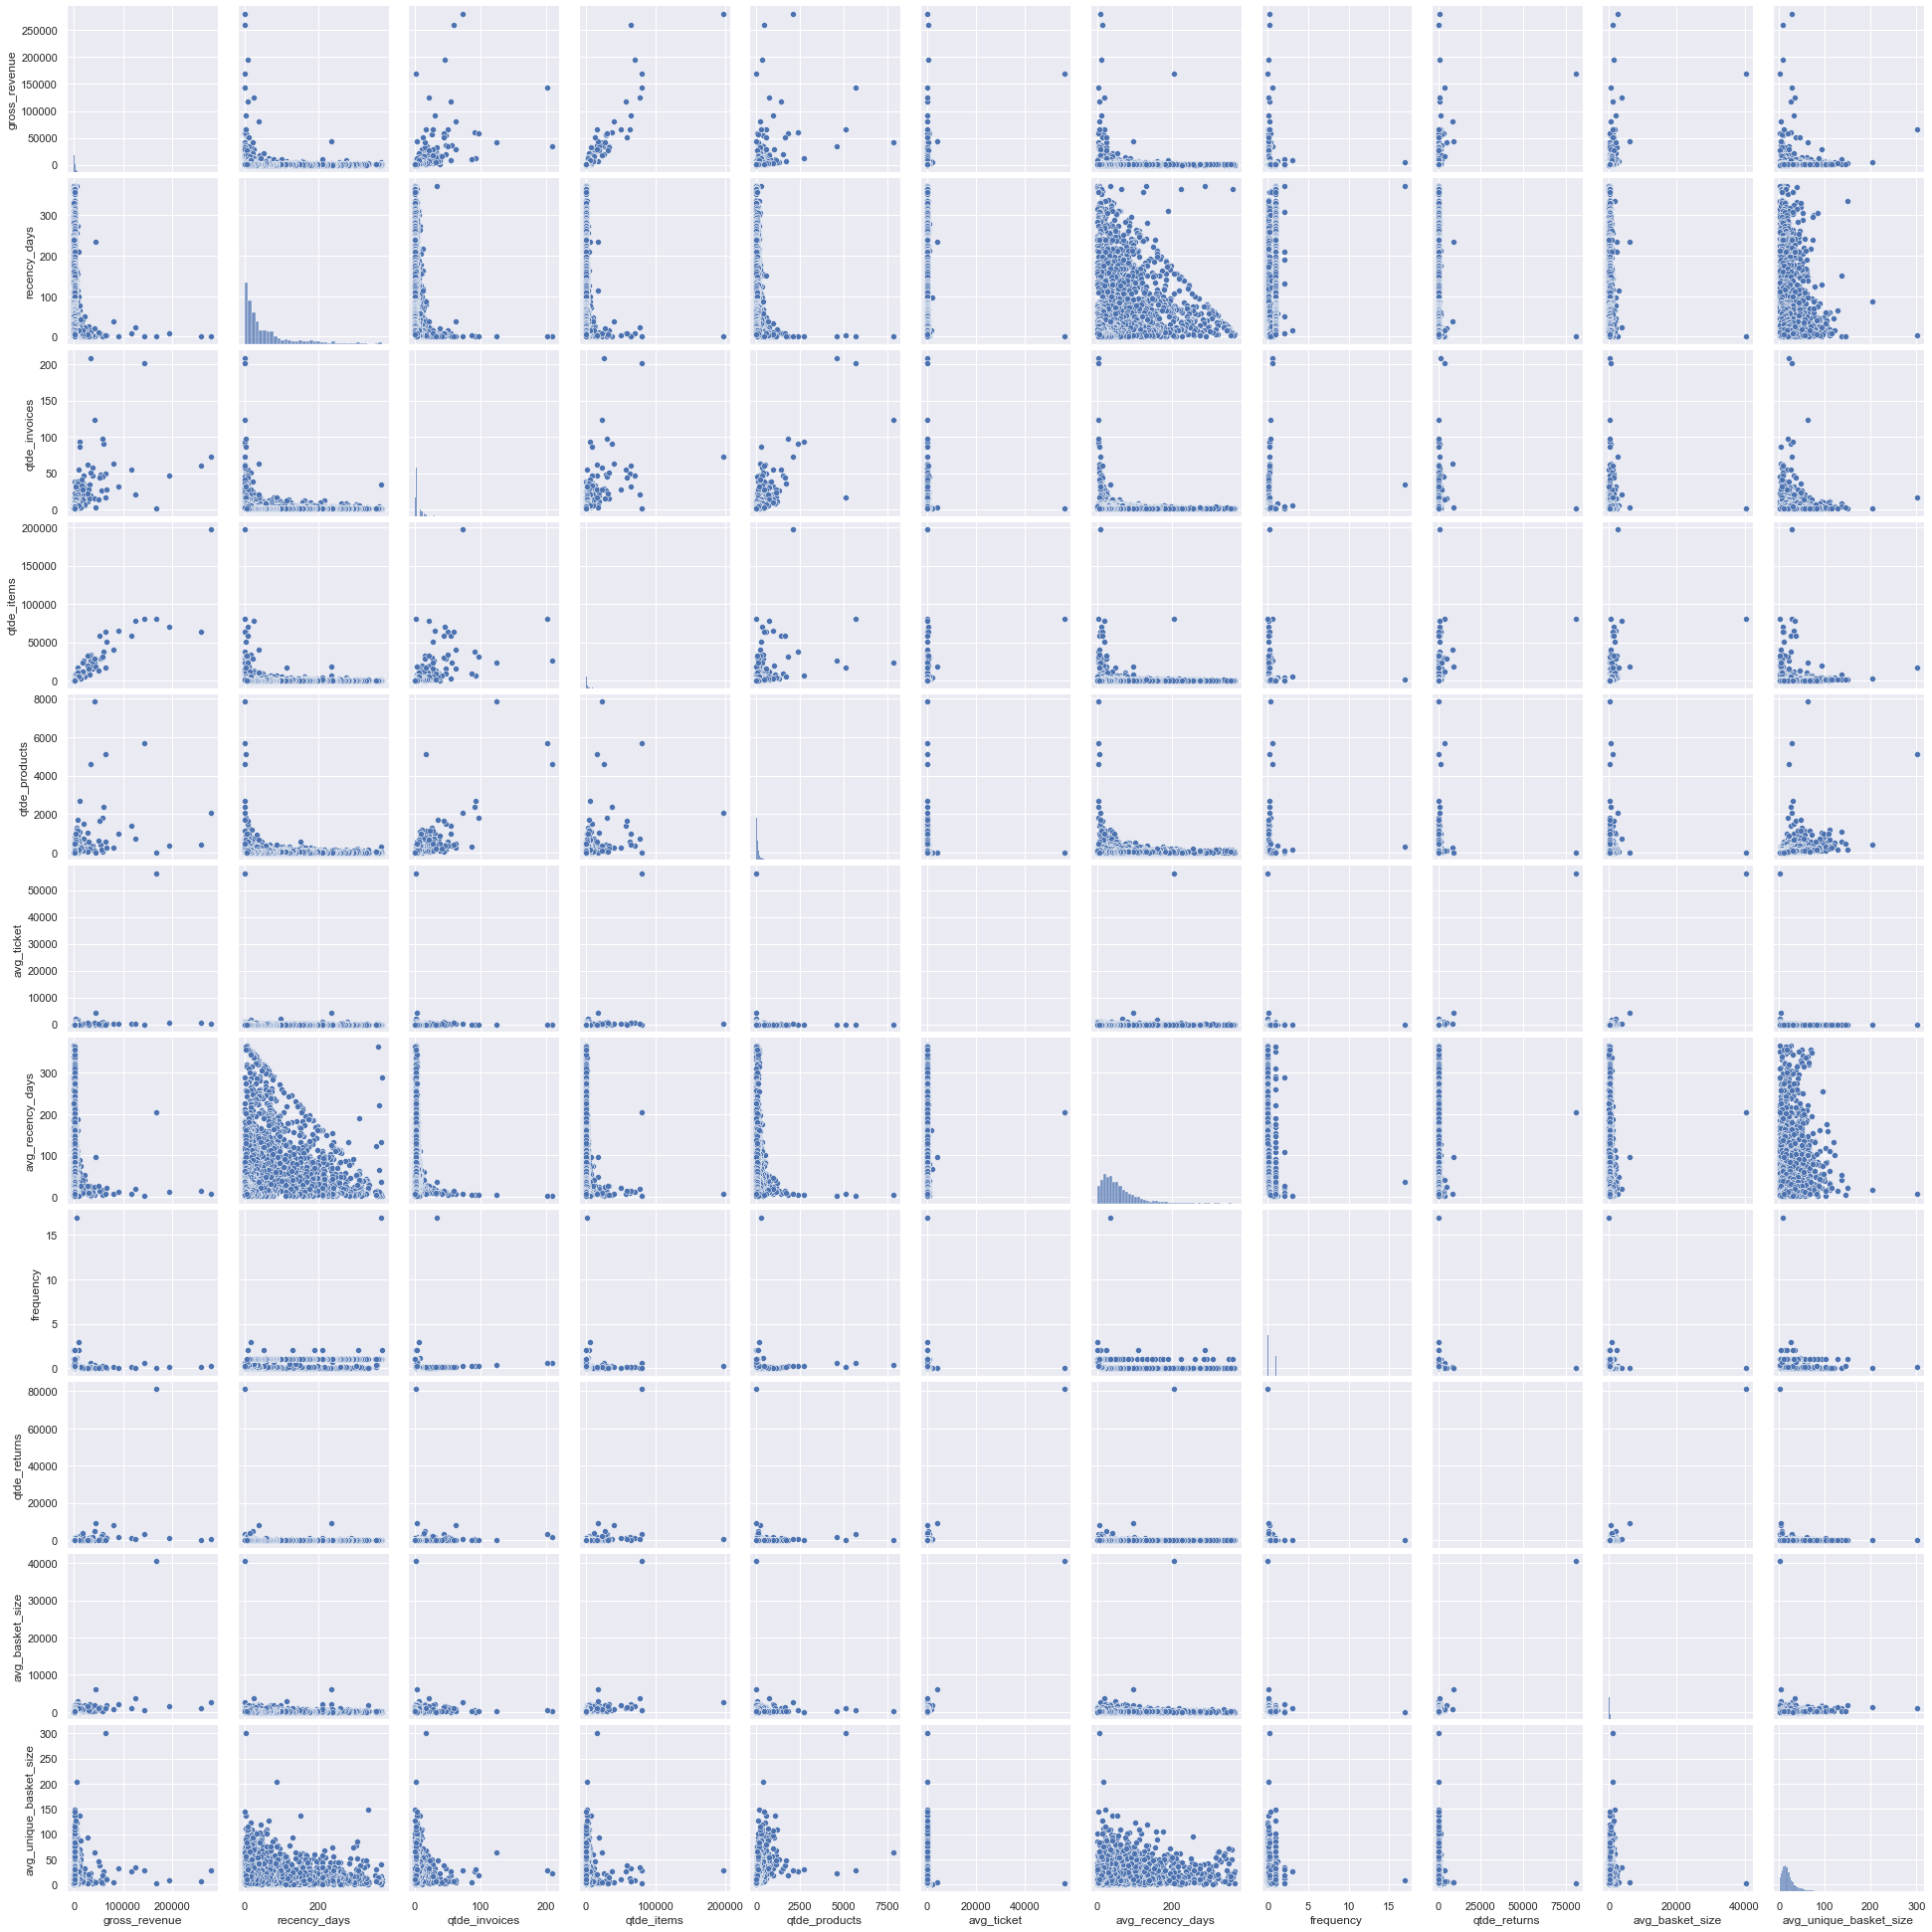

In [84]:
plt.figure( figsize=(25, 12) )
sns.pairplot( df42 )

# 4.3 Estudo do Espaço

In [85]:
df43 = df4.drop( columns=['customer_id'], axis=1 ).copy()

In [86]:
from sklearn import preprocessing as pp

In [87]:
mm = pp.MinMaxScaler()

 
df43['gross_revenue']          = mm.fit_transform( df43[['gross_revenue']] )
df43['recency_days']           = mm.fit_transform( df43[['recency_days']] )
df43['qtde_invoices']          = mm.fit_transform( df43[['qtde_invoices']])
df43['qtde_items']             = mm.fit_transform( df43[['qtde_items']])
df43['qtde_products']          = mm.fit_transform( df43[['qtde_products']])
df43['avg_ticket']             = mm.fit_transform( df43[['avg_ticket']])
df43['avg_recency_days']       = mm.fit_transform( df43[['avg_recency_days']])
df43['frequency']              = mm.fit_transform( df43[['frequency']])
df43['qtde_returns']           = mm.fit_transform( df43[['qtde_returns']])
df43['avg_basket_size']        = mm.fit_transform( df43[['avg_basket_size']])
df43['avg_unique_basket_size'] = mm.fit_transform( df43[['avg_unique_basket_size']] )


X = df43.copy()

## 4.3.1 PCA

In [88]:
from sklearn import decomposition as dd

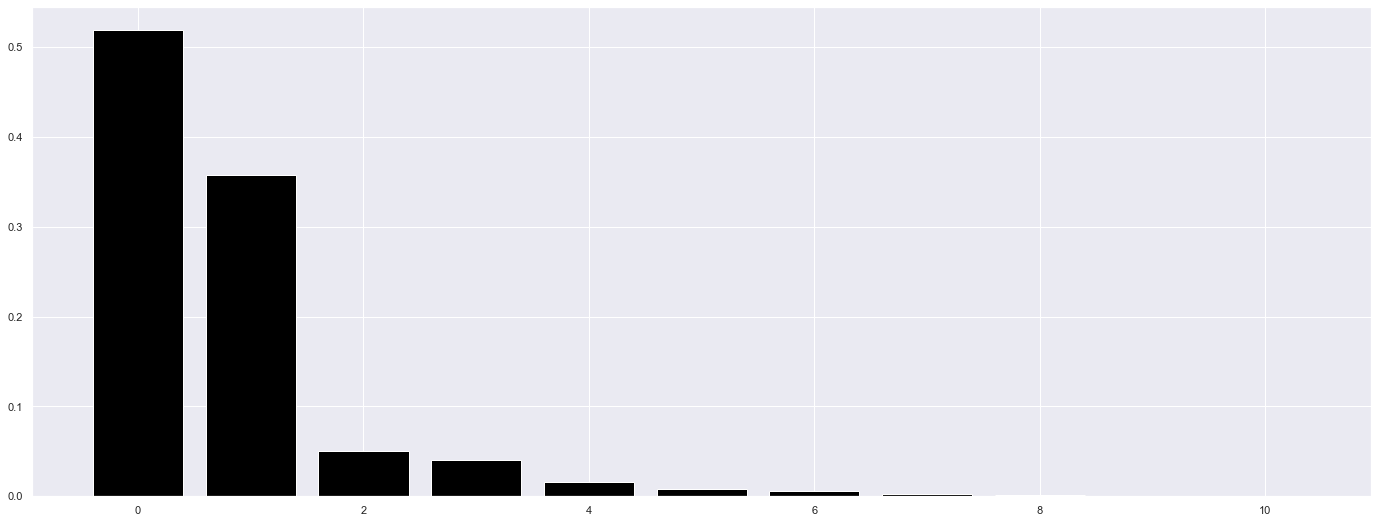

In [89]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

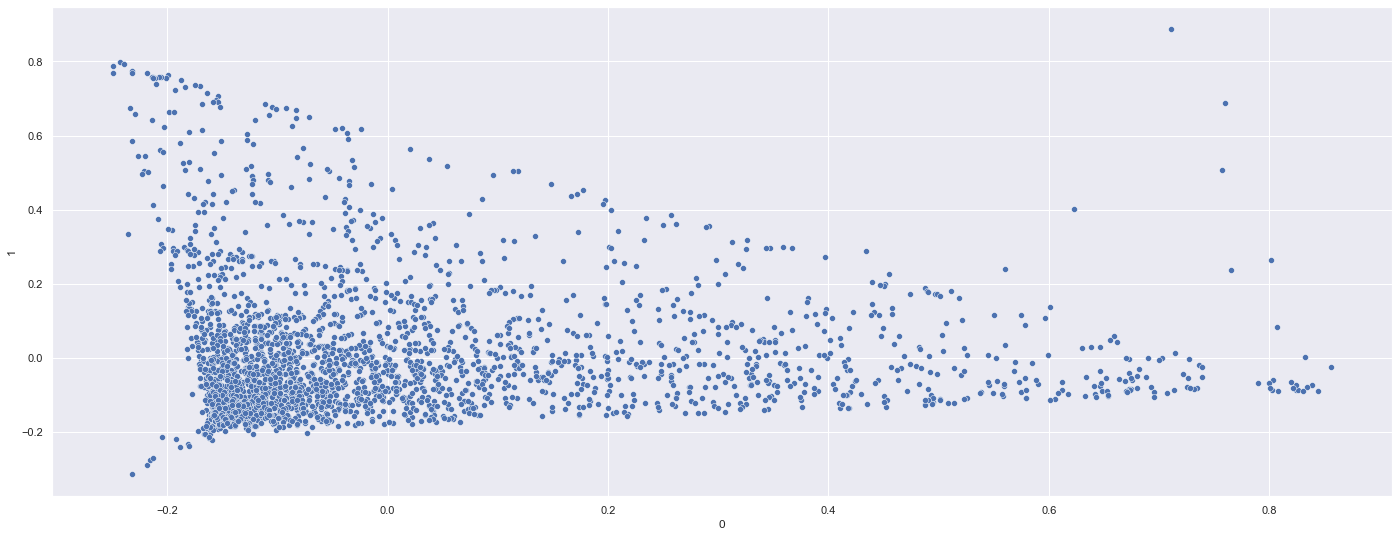

In [90]:
sns.scatterplot( x=0, y=1, data=df_pca );

## 4.3.2 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

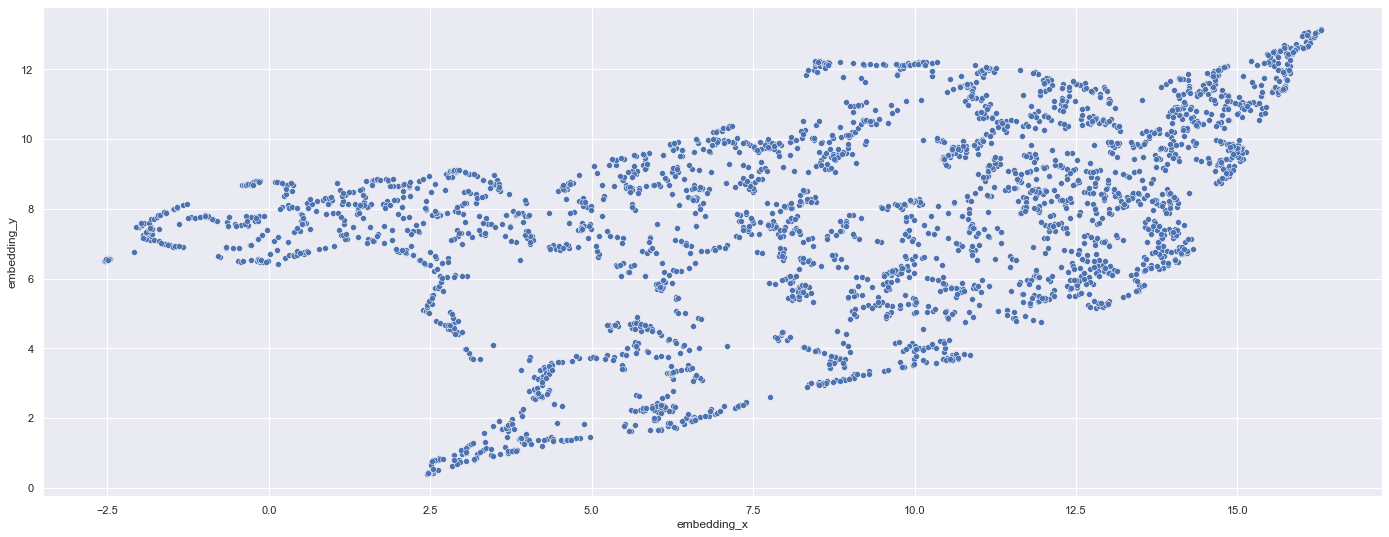

In [91]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_pca )

## 4.3.3 t-SNE

In [92]:
from sklearn.manifold import TSNE

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

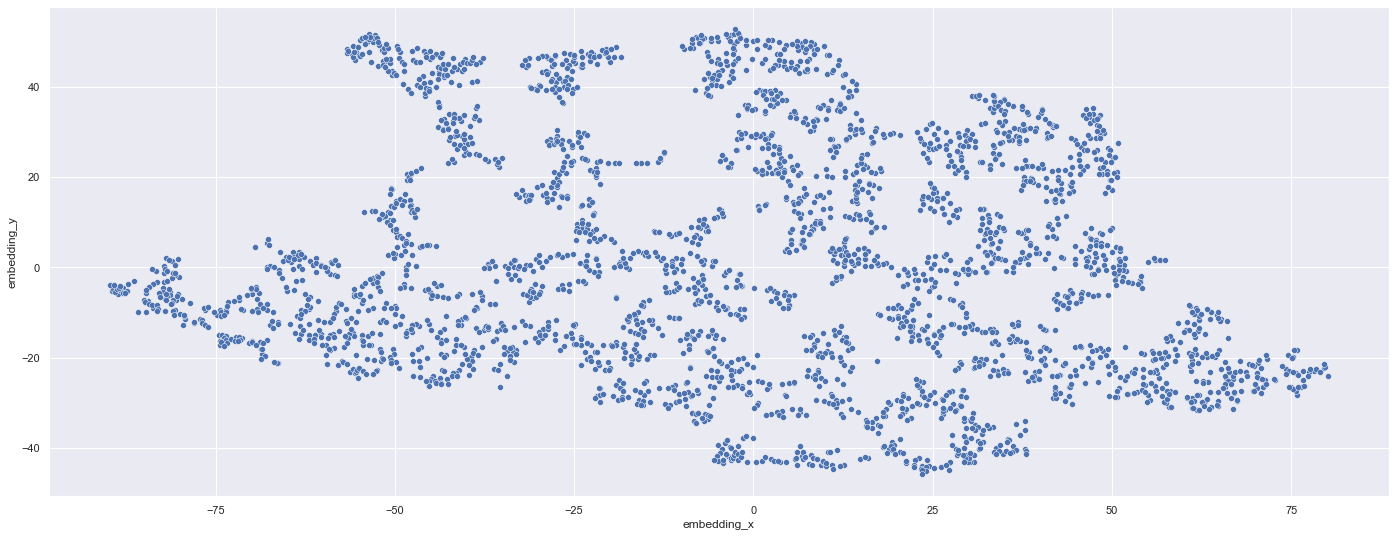

In [93]:
reducer = TSNE( n_components=2, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_pca )

## 4.3.4 Tree-Based Embedding

In [94]:
from sklearn import ensemble as en

In [95]:
# training dataset
X = df4.drop( columns=['customer_id', 'gross_revenue'], axis=1 )
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, random_state=42 )

# model training
rf_model.fit( X, y )

RandomForestRegressor(random_state=42)

In [96]:
df_leaf = pd.DataFrame( rf_model.apply( X ) )

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

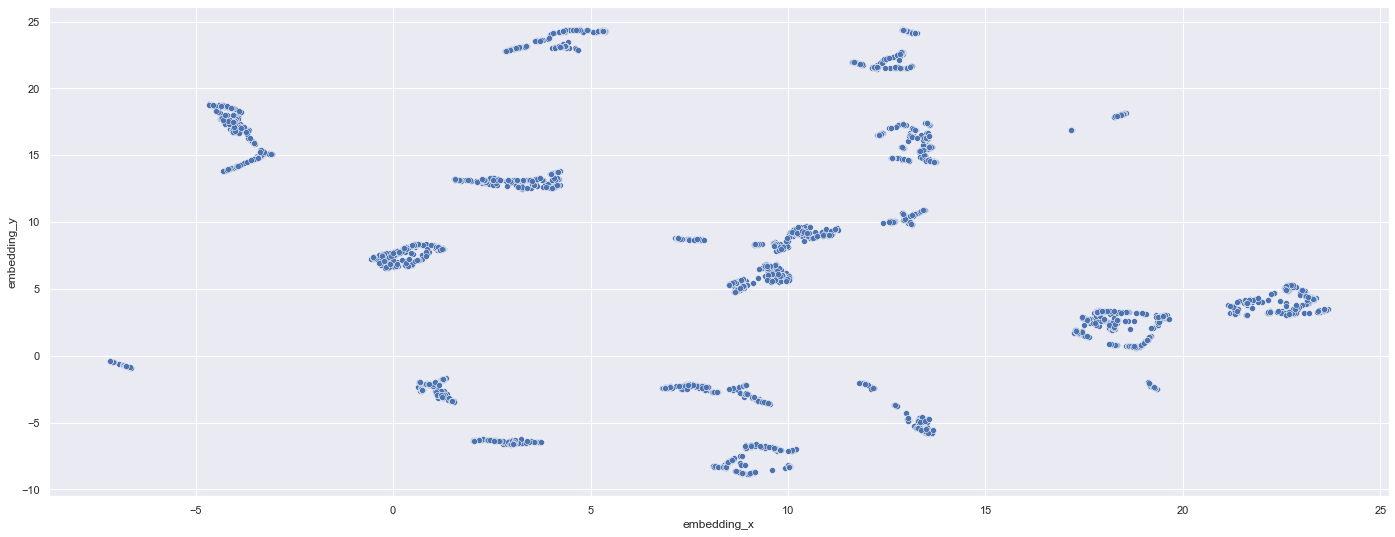

In [103]:
# Reducer dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tree )

# 5.0 DATA PREPARATION

1 - Distribuiçåo Normal e não possui Outlier -> Standard Scaler - Media e desvio padrao

2 - Distribuiçåo Normal e possuí Outlier -> Robust Scaler - Quartis

3 - Não distribuição normal -> Min Max Scaler

In [104]:
#df5 = df4.copy()
df5 = df_tree.copy()

In [105]:
df5.head()

,embedding_x,embedding_y
0,13.176893,24.183867
1,13.559838,17.324577
2,-3.548221,16.002644
3,19.288439,-2.419166
4,9.546607,-3.575234


In [78]:
 ## Standard Scalaer
#ss = pp.StandardScaler()

#df5['gross_revenue'] = ss.fit_transform( df5[['gross_revenue']] )
#df5['recency_days'] = ss.fit_transform( df5[['recency_days']] )
#df5['invoice_no'] = ss.fit_transform( df5[['invoice_no']] )
#df5['avg_ticket'] = ss.fit_transform( df5[['avg_ticket']] )

In [79]:
df4.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,34.0,1733.0,297.0,18.152222,35.500000,17.000000,40.0,50.970588,8.735294
1,13047,3237.54,31.0,10.0,1391.0,172.0,18.822907,26.307692,0.029155,36.0,139.100000,17.200000
2,12583,7281.38,2.0,15.0,5060.0,247.0,29.479271,21.823529,0.040323,51.0,337.333333,16.466667
3,13748,948.25,95.0,5.0,439.0,28.0,33.866071,92.666667,0.017921,0.0,87.800000,5.600000
4,15100,876.00,333.0,3.0,80.0,3.0,292.000000,8.600000,0.073171,22.0,26.666667,1.000000


# 6.0 FEATURE SELECTION

In [107]:
#cols_selected = ['customer_id', 'gross_revenue', 'recency_days', 'qtde_products', 'frequency', 'qtde_returns']

In [108]:
#df6 = df5[cols_selected].copy()
df6 = df_tree.copy()

# 7.0 HYPER PARAMETER FINE TUNING

In [76]:
#df7 = df6.copy()

In [109]:
X = df_tree.copy()

In [111]:
X.head()

,embedding_x,embedding_y
0,13.176893,24.183867
1,13.559838,17.324577
2,-3.548221,16.002644
3,19.288439,-2.419166
4,9.546607,-3.575234


In [113]:
#clusters = [2, 3, 4, 5, 6, 7]
clusters = np.arange( 2, 25, 1 )
clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24])

## 7.1 K-means

In [116]:
from sklearn import metrics as m

In [117]:
kmeans_list = []

for k in clusters:
    # model definition
    kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42 )

    # model training
    kmeans.fit( X )

    # model predict
    labels = kmeans.predict( X )

    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    kmeans_list.append( sil )

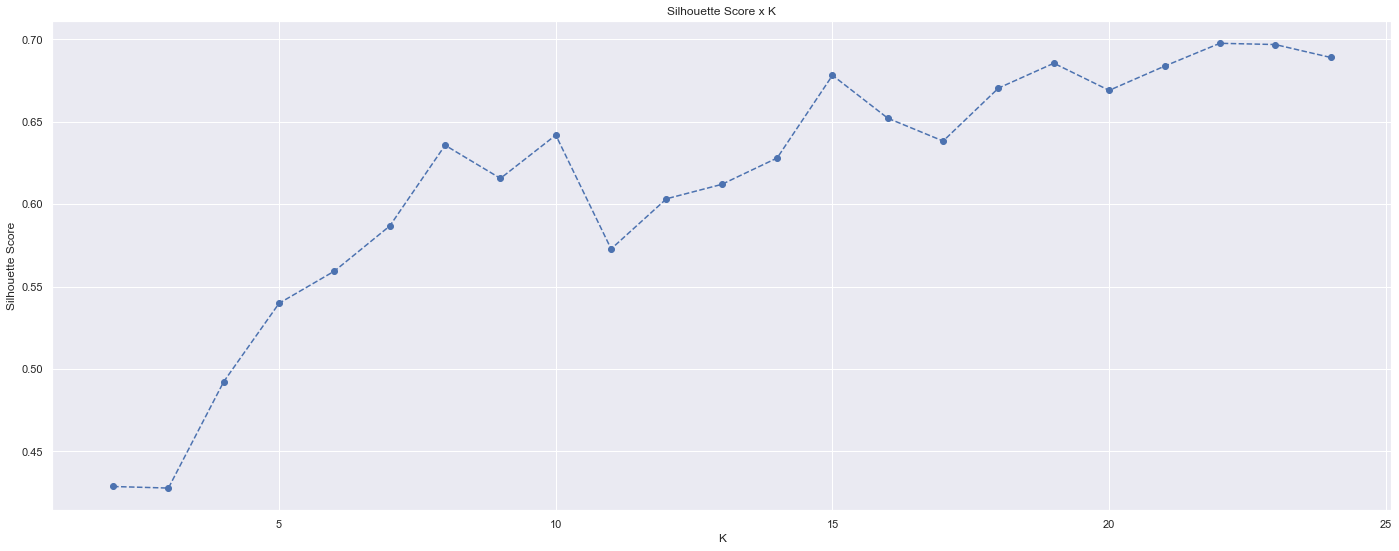

In [118]:
plt.plot( clusters, kmeans_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'K' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Silhouette Score x K' );

## 8.2 GMM

In [119]:
from sklearn.mixture import GaussianMixture

In [120]:
gmm_list = []

for k in clusters:
    
    # model definition
    gmm = GaussianMixture( n_components=k )
    # model training
    gmm.fit( X )
    # model predict
    labels = gmm.predict( X )
    # model performance
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    gmm_list.append( sil )

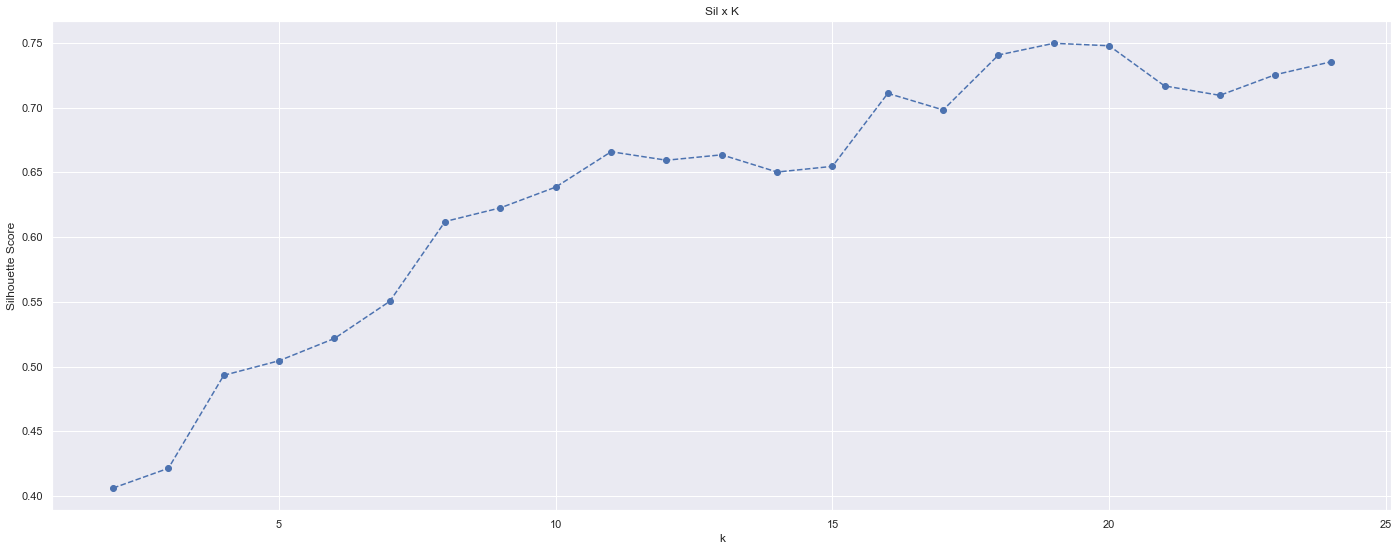

In [121]:
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k' );
plt.ylabel( 'Silhouette Score' );
plt.title( 'Sil x K' );

## 7.3 Hierarchical Clustering

In [122]:
from scipy.cluster import hierarchy as hc

In [123]:
# model definition and training
hc_model = hc.linkage( X, 'ward' )

[]

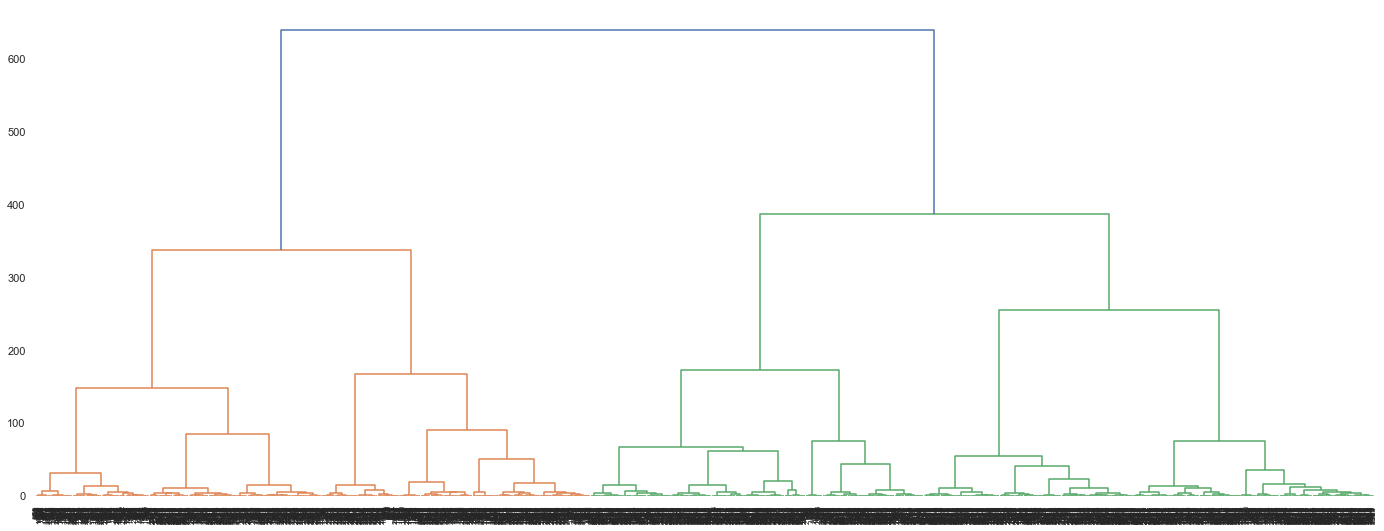

In [125]:
#hc.dendrogram( 
#    hc_model, 
#    leaf_rotation=90,
#    leaf_font_size=8
#)
#
#plt.plot()

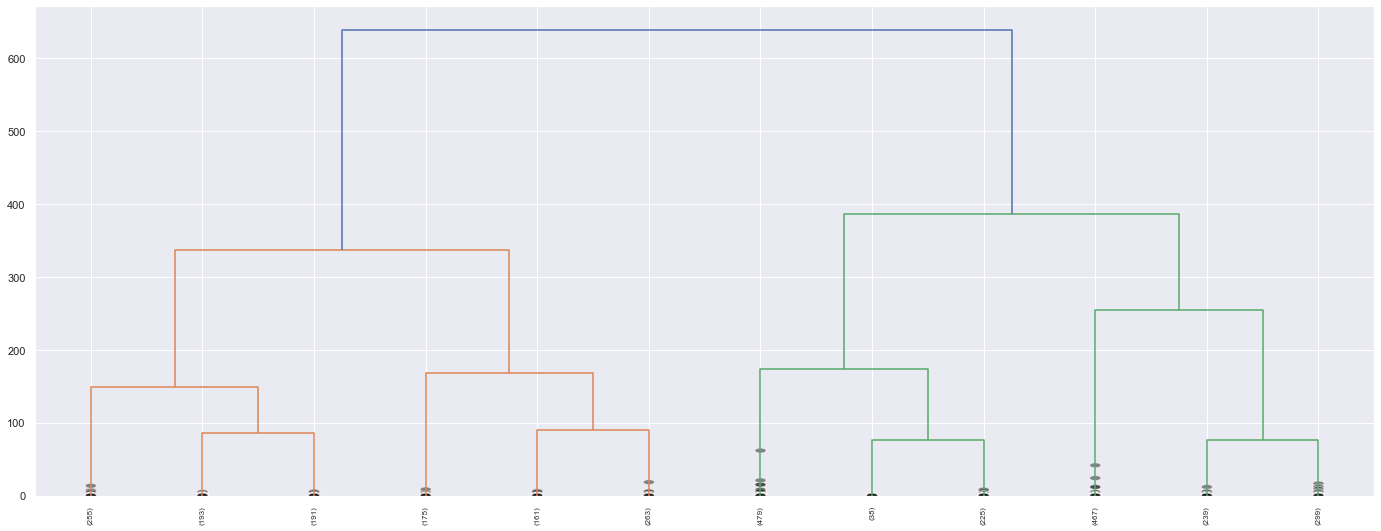

In [126]:
#hc.dendrogram( 
#    hc_model,
#    truncate_mode='lastp',
#    p=12,
#    leaf_rotation=90,
#    leaf_font_size=8,
#    show_contracted=True
#)
#
#plt.show()

### 7.3.1 HClustering Silhouette Score

In [127]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = m.silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

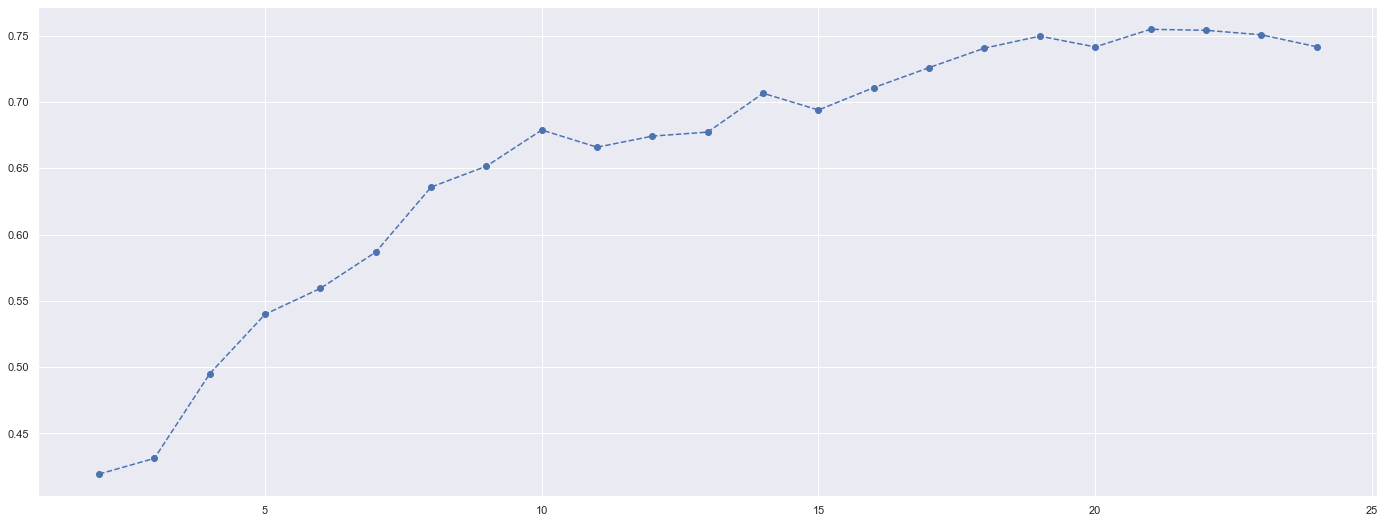

In [128]:
plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='b' )

## 7.4 DBSCAN

In [129]:
eps=2.00
min_samples=20 

# model definition
dbscan_model = c.DBSCAN( eps=eps, min_samples=min_samples )

# mode training & predict 
labels = dbscan_model.fit_predict( X )

sil = m.silhouette_score( X, labels, metric='euclidean' )
print( 'Silhouette Score: {}'.format( sil ) )
print( 'Number of Clusters: {}'.format( len( unique( labels ) ) ) )
print( unique( labels ) )

Silhouette Score: 0.703481137752533
Number of Clusters: 16
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [130]:
from sklearn.neighbors import NearestNeighbors

In [131]:
neighbors = NearestNeighbors( n_neighbors=min_samples ).fit( X )
distances, indices = neighbors.kneighbors( X )

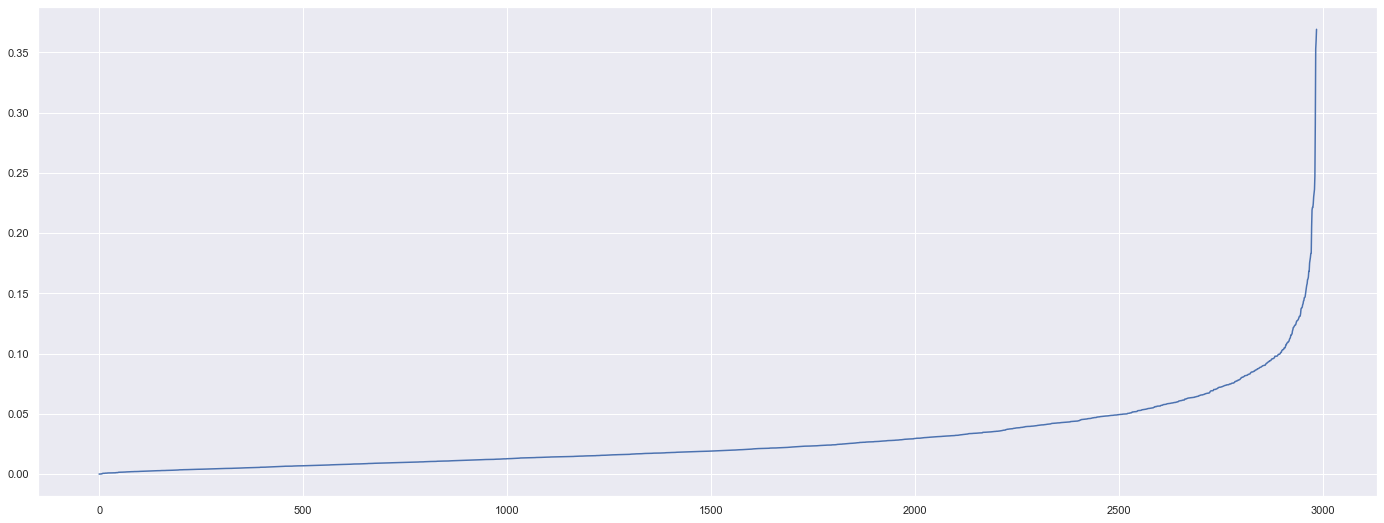

In [132]:
distances = np.sort( distances, axis=0 )
distances = distances[:,1]
plt.plot( distances )

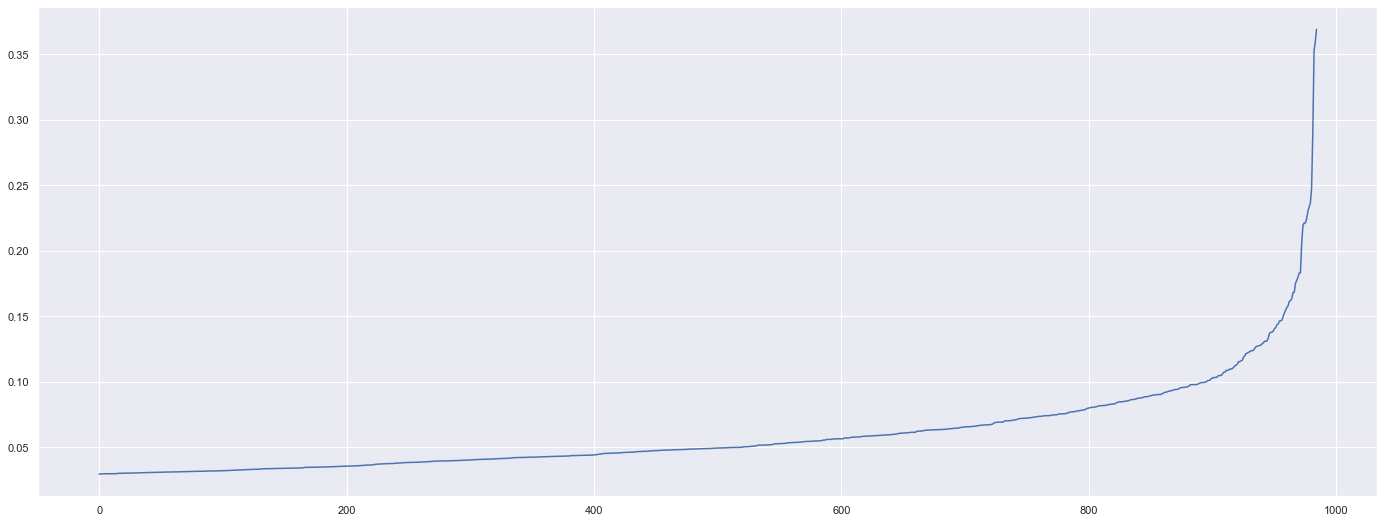

In [133]:
plt.plot( distances[2000:] )

In [134]:
dbscan_list = [ 0.622034, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

## 7.5 Results

In [135]:
df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list}
     #'DBSCAN': dbscan_list}
).T

df_results.columns = clusters

In [136]:
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
KMeans,0.428698,0.427750,0.492337,0.539899,0.559436,0.586812,0.635827,0.615700,0.641979,0.572880,0.603318,0.612078,0.628081,0.678258,0.652219,0.638364,0.670515,0.685588,0.669125,0.683805,0.697693,0.696943,0.689117
GMM,0.406098,0.421369,0.493197,0.504462,0.521662,0.550350,0.612020,0.622582,0.638629,0.665925,0.659353,0.663540,0.650230,0.654625,0.711035,0.698220,0.740643,0.749686,0.747786,0.716777,0.709480,0.725386,0.735297
HC,0.419369,0.431229,0.495080,0.539899,0.559436,0.586812,0.635827,0.651616,0.678893,0.665925,0.674297,0.677336,0.706601,0.693991,0.710890,0.725963,0.740643,0.749686,0.741545,0.754866,0.754120,0.750718,0.741743


## 7.1 Silhouette Analysis

 For K = 2. Silhouette Score: 0.41936931014060974
 For K = 3. Silhouette Score: 0.43122902512550354
 For K = 4. Silhouette Score: 0.49508026242256165
 For K = 5. Silhouette Score: 0.5398988127708435
 For K = 6. Silhouette Score: 0.5594359636306763
 For K = 7. Silhouette Score: 0.5868121385574341


IndexError: index 3 is out of bounds for axis 0 with size 3

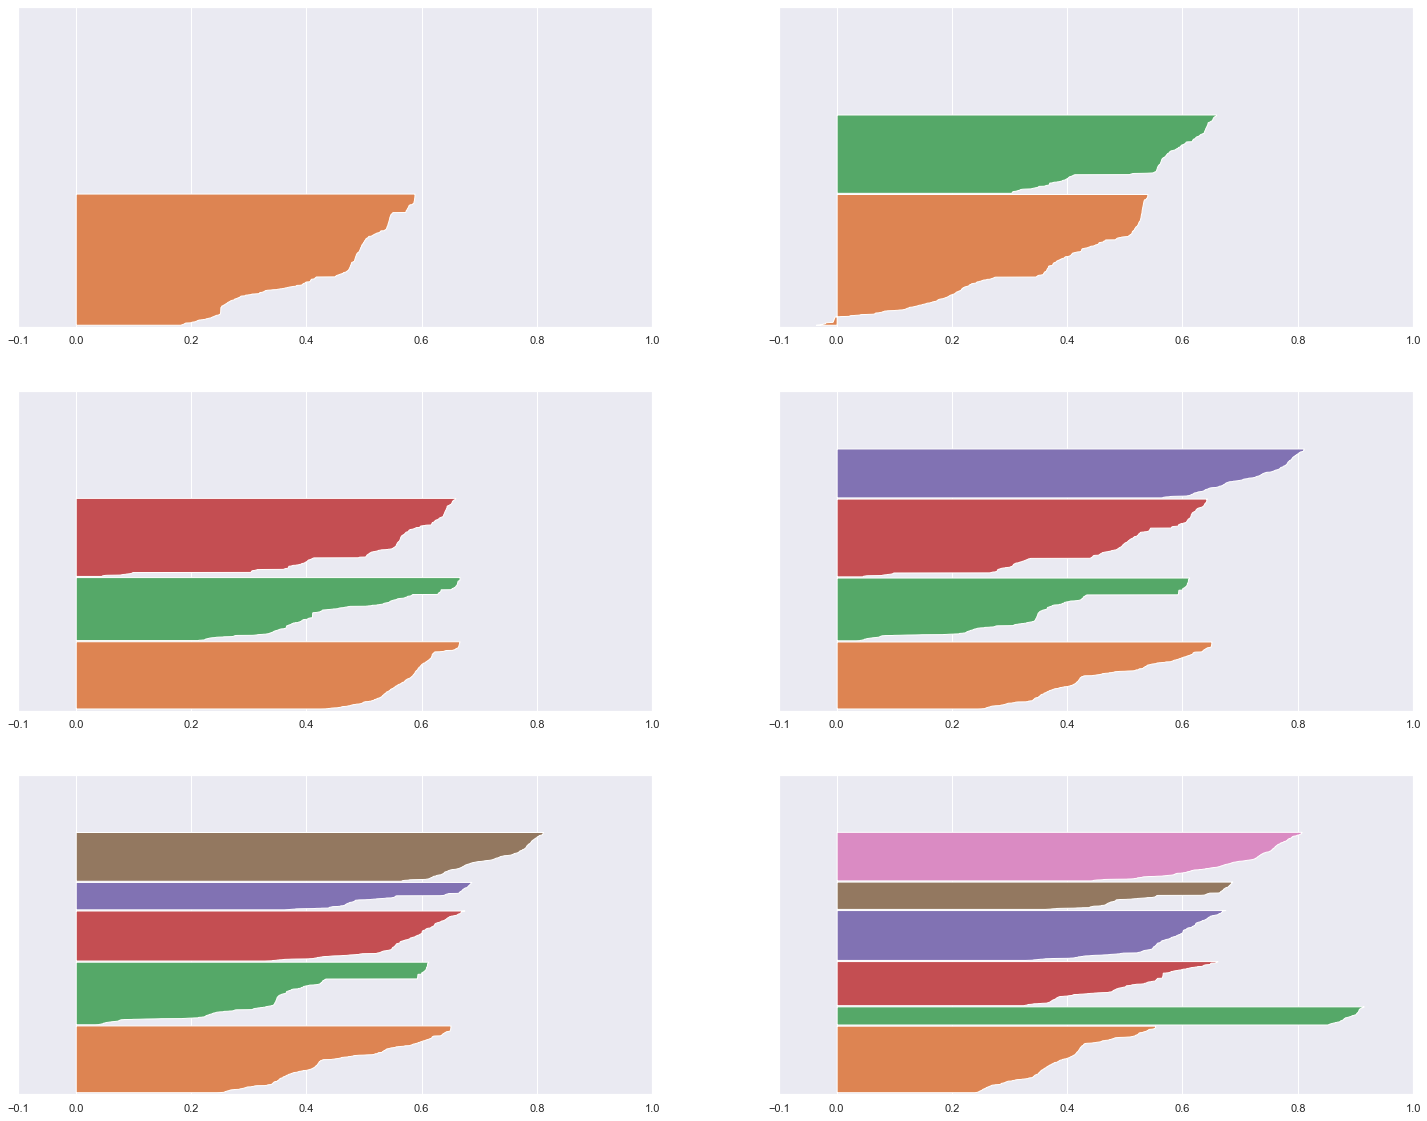

In [139]:
fig, ax = plt.subplots( 3, 2 )
fig.set_size_inches( 25, 20 )

for k in clusters:
    q, mod = divmod( k, 2 )
    
    ax[q-1, mod].set_xlim( [ -0.1, 1] )
    ax[q-1, mod].set_ylim( [ 0, len( X ) + ( k+1 )*10] )
    
    # model definition & training
    hc_model = hc.linkage( X, 'ward' )

    # model predict
    labels = hc.fcluster( hc_model, k, criterion='maxclust' )

    # performance
    ss = m.silhouette_score( X, labels, metric='euclidean' )
    print( ' For K = {}. Silhouette Score: {}'.format( k, ss ) )

    samples_silhouette_values = m.silhouette_samples( X, labels )

    y_lower = 10
    for i in range( k ):

        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[ labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()

        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap( 'Spectral' )
        color = cmap( i / k )

        ax[q-1, mod].fill_betweenx( np.arange( y_lower, y_upper ), 0, ith_samples_silhouette_values  )
        
        y_lower = y_upper + 10
        
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks( [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 8.0 Model Training

In [141]:
from sklearn import mixture       as mx

## 8.1 K-Means

In [ ]:
## model definition
#k = 8
#kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, max_iter=300 )
#
## model training
#kmeans.fit( X )
#
## clustering
#labels = kmeans.labels_

In [145]:
k=9
# model definition
kmeans = mx.GaussianMixture( n_components=k )

# model training
kmeans.fit( X )

# model predict
labels = kmeans.predict( X )

## 8.2 Cluster Validation

In [146]:
from sklearn import metrics as m

In [144]:
# WSS ( Within-cluster sum of square)
print( 'WSS Value: {}'.format( kmeans.inertia_ ) )

# SS (Silhouette Score)
print( 'SS Value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) )


AttributeError: 'GaussianMixture' object has no attribute 'inertia_'

# 9.0 CLUSTER ANALYSIS

In [147]:
X.head()

,embedding_x,embedding_y
0,13.176893,24.183867
1,13.559838,17.324577
2,-3.548221,16.002644
3,19.288439,-2.419166
4,9.546607,-3.575234


In [148]:
df9 = X.copy()
df9['cluster'] = labels

In [149]:
df9.head()

,embedding_x,embedding_y,cluster
0,13.176893,24.183867,2
1,13.559838,17.324577,2
2,-3.548221,16.002644,5
3,19.288439,-2.419166,7
4,9.546607,-3.575234,3


## 9.1 Visualization inspection

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

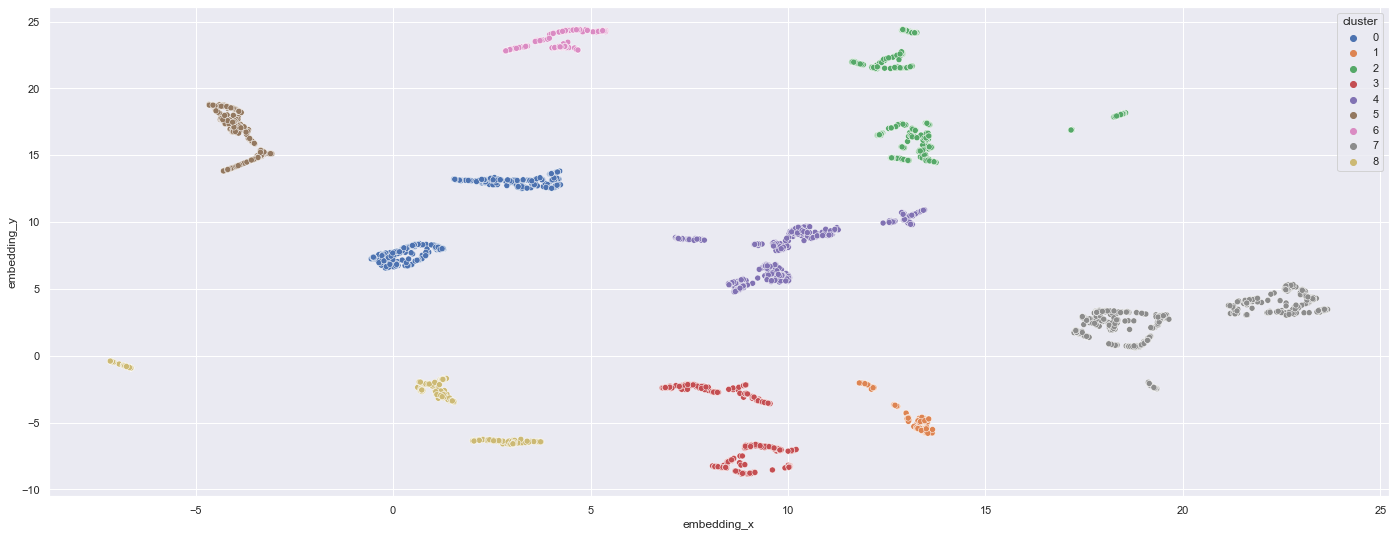

In [150]:
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep')

In [90]:
#visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick' )
#visualizer.fit( X )
#visualizer.finalize()

NameError: name 'SilhouetteVisualizer' is not defined

## 9.2. 2d plot

In [155]:
df_viz = df9.drop( columns='customer_id', axis=1 )
#sns.pairplot( df_viz, hue='cluster' )

## 9.3. UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

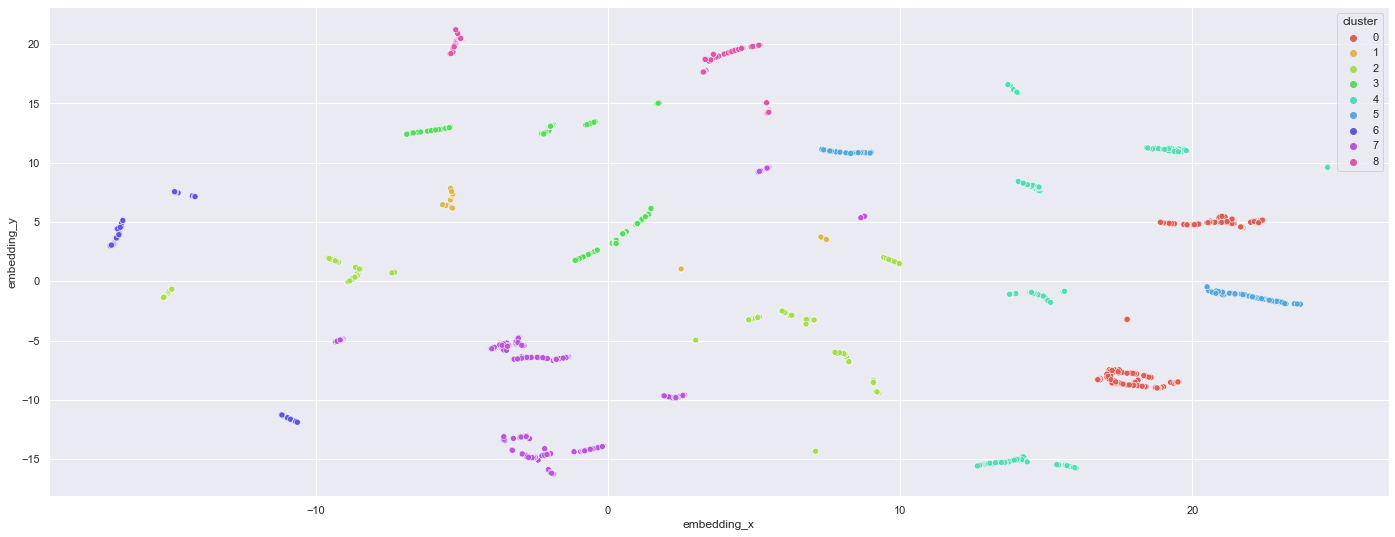

In [156]:
reducer = umap.UMAP( n_neighbors=90, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', 
                 hue='cluster', 
                 palette=sns.color_palette( 'hls', n_colors=len( df_viz['cluster'].unique() ) ),
                 data=df_viz )

## 9.4 Cluster Profile

In [157]:
df9.head()

,embedding_x,embedding_y,cluster
0,13.176893,24.183867,2
1,13.559838,17.324577,2
2,-3.548221,16.002644,5
3,19.288439,-2.419166,7
4,9.546607,-3.575234,3


In [158]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_invoice_no, how='inner', on='cluster' )



df_cluster

KeyError: "['customer_id'] not in index"

### Cluster 01 (prospective insiders)

- Total customers: 6 (0.14% of customers )
- Average Recency: 7 days
- Average purchases: 89 purchases
- Average Revenue: $182.182,00 dólares

### Cluster 02:

- Total customers: 31 (0.71% of customers )
- Average Recency: 14 days
- Average purchases: 53 purchases
- Average Revenue: $40.543,52 dólares

### Cluster 03:

- Total customers: 4.335 (99% of customers )
- Average Recency: 92 days
- Average purchases: 5 purchases
- Average Revenue: $1.372,57 dólares

# 10.0 DEPLOY TO PRODUCTION